In [1]:
import torch
import json
import matplotlib.pyplot as plt

import pandas as pd

from transformers import OPTForCausalLM, AutoTokenizer
from datasets import load_dataset, Dataset



In [2]:
def json_pretty(json_string):
    print(json.dumps(json_string,indent=4))
    return None

def label_to_text(label):
    return ["entailment", "neutral", "contradiction"][label]

def teacher_create_prompt(premise, hypothesis, label=None):
    prompt = f"\nPremise: {premise}, \nHypothesis: {hypothesis}"
    if label is not None:
        prompt += f",\nLabel: {label_to_text(label)}"
    if label is None:
        prompt += f",\nLabel:"
    return prompt

def student_create_prompt(premise, hypothesis, label=None):
    prompt = f"Label if this is entailment or contradiction.\nPremise: {premise},\nHypothesis: {hypothesis},\nLabel:"
    return prompt

def create_extended_prompt(context_examples, query_example):
    context_prompt = ""
    for example in context_examples:
        premise = example['premise']
        hypothesis = example['hypothesis']
        label = example['label']
        context_prompt += teacher_create_prompt(premise, hypothesis, label) + "\n"
    
    query_premise = query_example['premise']
    query_hypothesis = query_example['hypothesis']
    query_prompt = teacher_create_prompt(query_premise, query_hypothesis) 
    return context_prompt + query_prompt

### Tokenizer + Models

In [3]:
tokenizer = AutoTokenizer.from_pretrained("facebook/opt-350m") # tokenizer
teacher_model = OPTForCausalLM.from_pretrained("facebook/opt-350m") # teacher model
student_model = OPTForCausalLM.from_pretrained("facebook/opt-350m") # student model

### Datasets 

In [4]:
dataset = load_dataset("nyu-mll/glue", "mnli", split='train')
dataset = dataset.filter(lambda example: example["label"] != 1)

validation_dataset = load_dataset("nyu-mll/glue", "mnli", split='validation_matched')
validation_dataset = validation_dataset.filter(lambda example: example["label"] != 1)


### Data Example

In [5]:
context_examples = [{key: value[i] for key, value in dataset[5:7].items()} for i in range(2)]
query_example = {key: value for key, value in dataset[7].items()}

In [6]:
json_pretty(context_examples)

[
    {
        "premise": "Gays and lesbians.",
        "hypothesis": "Heterosexuals.",
        "label": 2,
        "idx": 8
    },
    {
        "premise": "At the end of Rue des Francs-Bourgeois is what many consider to be the city's most handsome residential square, the Place des Vosges, with its stone and red brick facades.",
        "hypothesis": "Place des Vosges is constructed entirely of gray marble.",
        "label": 2,
        "idx": 9
    }
]


In [7]:
json_pretty(query_example)

{
    "premise": "I burst through a set of cabin doors, and fell to the ground-",
    "hypothesis": "I burst through the doors and fell down.",
    "label": 0,
    "idx": 10
}


### Prompt Example

In [8]:
teacher_prompt = create_extended_prompt(context_examples, query_example)
student_prompt = student_create_prompt(query_example['premise'], query_example['hypothesis'])

teacher_inputs = tokenizer(teacher_prompt, return_tensors="pt")
student_inputs = tokenizer(student_prompt, return_tensors="pt")

print(teacher_prompt)


Premise: Gays and lesbians., 
Hypothesis: Heterosexuals.,
Label: contradiction

Premise: At the end of Rue des Francs-Bourgeois is what many consider to be the city's most handsome residential square, the Place des Vosges, with its stone and red brick facades., 
Hypothesis: Place des Vosges is constructed entirely of gray marble.,
Label: contradiction

Premise: I burst through a set of cabin doors, and fell to the ground-, 
Hypothesis: I burst through the doors and fell down.,
Label:


In [9]:
teacher_outputs_1 = teacher_model.generate(**teacher_inputs, max_length=teacher_inputs['input_ids'].shape[-1] + 1, output_scores=True, return_dict_in_generate=True)
teacher_probs_1 = torch.nn.functional.softmax(teacher_outputs_1.scores[0], dim=-1)
print(tokenizer.decode(teacher_outputs_1[0][0][-1], skip_special_tokens=True))
print(teacher_outputs_1[0].shape, teacher_outputs_1.scores[0].shape)

argmax_index = torch.argmax(teacher_outputs_1.scores[0])
print(teacher_probs_1.shape)


 contradiction
torch.Size([1, 132]) torch.Size([1, 50272])
torch.Size([1, 50272])


### Student model training

In [10]:
student_model.train()

OPTForCausalLM(
  (model): OPTModel(
    (decoder): OPTDecoder(
      (embed_tokens): Embedding(50272, 512, padding_idx=1)
      (embed_positions): OPTLearnedPositionalEmbedding(2050, 1024)
      (project_out): Linear(in_features=1024, out_features=512, bias=False)
      (project_in): Linear(in_features=512, out_features=1024, bias=False)
      (layers): ModuleList(
        (0-23): 24 x OPTDecoderLayer(
          (self_attn): OPTAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (activation_fn): ReLU()
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=409

In [11]:
student_outputs = student_model.generate(**student_inputs, max_length=student_inputs['input_ids'].shape[-1] + 2)
s_output_text = tokenizer.decode(student_outputs[0], skip_special_tokens=True)
predicted_label = s_output_text.split("Label:")[-1].strip().split('.')[0].strip()
print(s_output_text)

Label if this is entailment or contradiction.
Premise: I burst through a set of cabin doors, and fell to the ground-,
Hypothesis: I burst through the doors and fell down.,
Label: I burst


In [12]:
# student_outputs = student_model.generate(**student_inputs, max_length=student_inputs['input_ids'].shape[-1] + 2)
# s_output_text = tokenizer.decode(student_outputs[0], skip_special_tokens=True)
# student_predicted_label = s_output_text.split("Label:")[-1].strip().split('.')[0].strip()
# print(s_output_text)

# student_outputs = student_model.generate(**student_inputs, max_length=student_inputs['input_ids'].shape[-1] + 1, output_scores=True, return_dict_in_generate=True)
# student_probs_1 = torch.nn.functional.softmax(student_outputs.scores[0], dim=-1)

# print(tokenizer.decode(student_outputs[0][0][-1], skip_special_tokens=True))
# print(student_outputs[0].shape, student_outputs.scores[0].shape)

# s_argmax_index = torch.argmax(student_outputs.scores[0])
# print(student_probs_1.shape, s_argmax_index)
# student_probs_1.requires_grad

student_logits = student_model(**student_inputs).logits 
student_probs_1 = torch.nn.functional.softmax(student_logits[:,-1,:], dim=-1)
student_probs_1.shape

torch.Size([1, 50272])

In [13]:
optimizer = torch.optim.AdamW(student_model.parameters(), lr=0.001)

kl_divergence = torch.nn.functional.kl_div(student_probs_1.log(), teacher_probs_1, reduction='batchmean')

print(kl_divergence)
kl_divergence.requires_grad

tensor(10.7571, grad_fn=<DivBackward0>)


True

In [14]:
total_loss = 0

optimizer.zero_grad()
kl_divergence.backward()
optimizer.step()

total_loss += kl_divergence.item()

print(f"1, Average Loss: {total_loss/len(query_example)}")

1, Average Loss: 2.689265727996826


In [15]:
student_outputs = student_model.generate(**student_inputs, max_length=student_inputs['input_ids'].shape[-1] + 1)
s_output_text = tokenizer.decode(student_outputs[0], skip_special_tokens=True)
predicted_label = s_output_text.split("Label:")[-1].strip().split('.')[0].strip()
print(s_output_text)
print("Label only:" , predicted_label)

Label if this is entailment or contradiction.
Premise: I burst through a set of cabin doors, and fell to the ground-,
Hypothesis: I burst through the doors and fell down.,
Label: contradiction
Label only: contradiction


In [16]:
def create_batches(dataset, context_size=2, batch_size=3):
    batch = []
    for index in range(0, len(dataset), context_size + 1):
        if index + batch_size > len(dataset):
            break  # Avoid going out of index range, discard last incomplete batch
        
        # Create batch: 2 context + 1 query
        context = dataset[index:index + context_size]
        query = dataset[index + context_size]

        # Collect and format data for the batch
        batch_data = {
            'context': [{key: value[i] for key, value in context.items()} for i in range(2)],
            'query': {key: value for key, value in query.items()}
        }
        batch.append(batch_data)
    
    return batch

# Subset of only 300 rows.
subset_dataset = dataset.select(range(300))
batches = create_batches(subset_dataset)

In [17]:
# Check if CUDA is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [18]:
# Assuming `losses` is the list of epoch losses returned from the `train` function
def plot_losses(losses):
    plt.figure(figsize=(10, 5))
    plt.plot(losses, marker='o', linestyle='-', color='b')
    plt.title('Training Loss Per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.grid(True)
    plt.show()


Epoch 1, Total Loss: 3.4099406362511218
Epoch 2, Total Loss: 1.5147778469448288
Epoch 3, Total Loss: 1.4931619986891747
Epoch 4, Total Loss: 1.4231533057366808
Epoch 5, Total Loss: 1.3566293749026954
Epoch 6, Total Loss: 1.382598176288108
Epoch 7, Total Loss: 1.3046206549430888
Epoch 8, Total Loss: 1.3357705281426508
Epoch 9, Total Loss: 1.2629393339157104
Epoch 10, Total Loss: 1.2486189100891352
Total loss : 0.7491713460534811


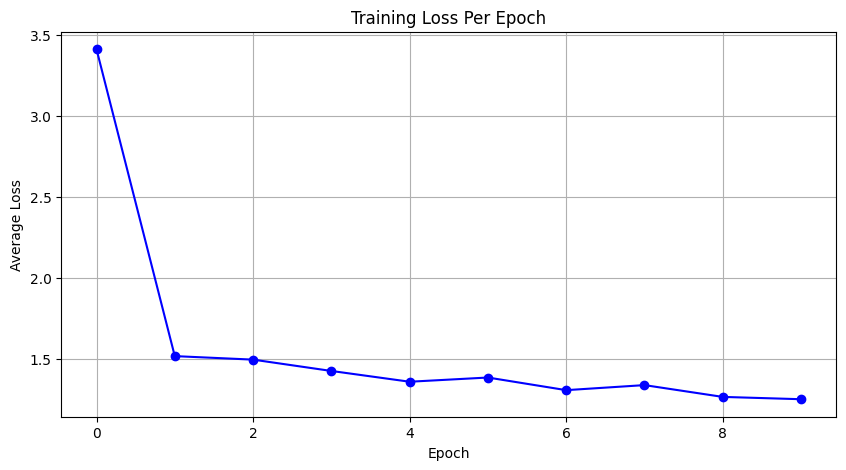

In [19]:
import torch

def train(data, epochs=10, batch_size=16, device='cpu'):
    student_model.to(device)
    teacher_model.to(device)
    
    student_model.train()
    optimizer = torch.optim.AdamW(student_model.parameters(), lr=0.001)
    epoch_losses = []


    for epoch in range(epochs):
        total_loss = 0
        num_batches = len(data) // batch_size 
        
        for i in range(num_batches):
            batch_loss = 0
            for j in range(batch_size):
                index = i * batch_size + j
                teacher_prompt = create_extended_prompt(data[index]['context'], data[index]['query'])
                student_prompt = student_create_prompt(data[index]['query']['premise'], data[index]['query']['hypothesis'])
                
                teacher_inputs = tokenizer(teacher_prompt, return_tensors="pt").to(device)
                student_inputs = tokenizer(student_prompt, return_tensors="pt").to(device)
                
                teacher_outputs = teacher_model.generate(**teacher_inputs, max_length=teacher_inputs['input_ids'].shape[-1] + 1, output_scores=True, return_dict_in_generate=True)
                teacher_probs = torch.nn.functional.softmax(teacher_outputs.scores[0], dim=-1)
                
                student_logits = student_model(**student_inputs).logits
                student_probs = torch.nn.functional.softmax(student_logits[:, -1, :], dim=-1)
                
                kl_divergence = torch.nn.functional.kl_div(student_probs.log(), teacher_probs, reduction='batchmean')
                
                optimizer.zero_grad()
                kl_divergence.backward()
                optimizer.step()

                batch_loss += kl_divergence.item()

            # Average loss for the batch
            batch_loss /= batch_size
            total_loss += batch_loss
            # print(f"Epoch {epoch + 1}, Batch {i + 1}, Average Loss: {batch_loss}")


        # Average loss for the epoch
        epoch_loss = total_loss / num_batches
        epoch_losses.append(epoch_loss)

        print(f"Epoch {epoch + 1}, Total Loss: {epoch_loss}")
        
    print(f"Total loss : {total_loss/epochs}")
    plot_losses(epoch_losses)
    torch.save(student_model, './models/student.pth')


train(batches, device=device)


In [20]:
student_logits = student_logits.to(device)
student_inputs = student_inputs.to(device)
student_outputs = student_model.generate(**student_inputs, max_length=student_inputs['input_ids'].shape[-1] + 1).to(device)
s_output_text = tokenizer.decode(student_outputs[0], skip_special_tokens=True)
predicted_label = s_output_text.split("Label:")[-1].strip().split('.')[0].strip()
print(s_output_text)
print("Label only:" , predicted_label)

Label if this is entailment or contradiction.
Premise: I burst through a set of cabin doors, and fell to the ground-,
Hypothesis: I burst through the doors and fell down.,
Label: contradiction
Label only: contradiction


In [21]:
def create_student_token(data, tokenizer, device = 'cpu'):
    tokens = []
    for i in range(len(data)):
        prompt = student_create_prompt(data[i]['premise'], data[i]['hypothesis'])
        tokens.append(tokenizer(prompt, return_tensors="pt").to(device))
    return tokens

tokens = create_student_token(validation_dataset, tokenizer, device)

In [22]:
def predict(model, source, target=None, device='cpu'):
    predict = []
    for token in source:
        output = model.generate(**token, max_length=token['input_ids'].shape[-1] + 1).to(device)
        decoded_output = tokenizer.decode(output[0], skip_special_tokens=True)
        predicted_label = decoded_output.split("Label:")[-1].strip().split('.')[0].strip()
        predict.append(predicted_label)
        
    return predict
   
predict = predict(student_model, tokens, device=device)  

In [23]:
label_mapping = {'contradiction': 2, 'entail': 0}
numberical_labels = [label_mapping[label] for label in predict]

In [24]:
def accuracy(prediction, actual):
    if len(prediction) != len(actual):
        raise ValueError("The length of predictions and actuals must be the same.")
    correct = sum(1 for pred, actual in zip(prediction, actual) if pred == actual)
    total = len(prediction)
    return correct / total if total > 0 else 0

accuracy = accuracy(numberical_labels, validation_dataset['label'])
print(accuracy)

0.5138971906754334
